In [4]:
import sys
import geopandas as gpd
import pandas as pd
import xarray as xr
from shapely.geometry import MultiPoint, LineString
from netCDF4 import Dataset
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

def process_data(netcdf_path, geojson_path, buffer_distance, spacing):
    # Load NetCDF file
    nc = Dataset(netcdf_path, 'r')
    pixel_cloud = nc.groups['pixel_cloud']

    # Extract variables
    latitude = pixel_cloud.variables['latitude'][:]
    longitude = pixel_cloud.variables['longitude'][:]
    height = pixel_cloud.variables['height'][:]
    water_frac = pixel_cloud.variables['water_frac'][:]
    coherent_power = pixel_cloud.variables['coherent_power'][:]
    classification = pixel_cloud.variables['classification'][:]
    missed_detection_rate = pixel_cloud.variables['missed_detection_rate'][:]
    geolocation_qual = pixel_cloud.variables['geolocation_qual'][:]
    nc.close()

    # Create a pandas DataFrame
    df_PIXC = pd.DataFrame({
        'latitude': latitude,
        'longitude': longitude,
        'height': height,
        'water_frac': water_frac,
        'coherent_power': coherent_power,
        'classification': classification,
        'missed_detection_rate': missed_detection_rate,
        'geolocation_qual': geolocation_qual
    })

    # Convert the DataFrame to an xarray Dataset
    ds = xr.Dataset.from_dataframe(df_PIXC)

    # Convert GeoJSON line to GeoDataFrame
    geojson_gdf = gpd.read_file(geojson_path)
    river = geojson_gdf.to_crs('EPSG:32718')

    # Buffer the line
    river_buffered = river.buffer(buffer_distance, cap_style='flat')
    river_buffered_gdf = gpd.GeoDataFrame(geometry=river_buffered, crs=river.crs)

    # Interpolate points along the line
    def interpolate_points(line, distance):
        num_points = int(line.length / distance)
        return MultiPoint([line.interpolate(i * distance) for i in range(num_points + 1)])

    # Apply interpolation
    points_gdf = river.geometry.apply(lambda x: interpolate_points(x, spacing))
    points_gdf = points_gdf.explode(index_parts=True).reset_index(drop=True)
    river_points = gpd.GeoDataFrame(geometry=points_gdf)

    # Calculate cumulative distance
    def calculate_cumulative_distance(gdf):
        gdf['prev_geometry'] = gdf['geometry'].shift()
        gdf['distance_to_prev'] = gdf.apply(lambda row: row['geometry'].distance(row['prev_geometry']) if pd.notna(row['prev_geometry']) else 0, axis=1)
        gdf['cumulative_distance'] = gdf['distance_to_prev'].cumsum()
        return gdf

    print(f'river_points crs: {river_points.crs}')
    
    river = calculate_cumulative_distance(river_points)
    river.reset_index(drop=True, inplace=True)

    river_cum_dis = river['cumulative_distance'].values

    print(f'river_cum_dis: {river_cum_dis[0:5]}')

    river_buffered_gdf = river_buffered_gdf.to_crs('epsg:4326')

    # Convert 'ds' to GeoDataFrame and clip to buffer
    ds_gdf = gpd.GeoDataFrame({
        'latitude': latitude,
        'longitude': longitude,
        'height': height,
        'water_frac': water_frac,
        'coherent_power': coherent_power,
        'classification': classification,
        'missed_detection_rate': missed_detection_rate,
        'geolocation_qual': geolocation_qual
    }, geometry=gpd.points_from_xy(df_PIXC['longitude'], df_PIXC['latitude']), crs="EPSG:4326")
    ds_clipped = gpd.sjoin(ds_gdf, river_buffered_gdf, how='inner', predicate='within')

    # Find nearest river point to each ds point
    river = river.to_crs('EPSG:32718')  # You may need to dynamically determine the EPSG code
    ds_clipped = ds_clipped.to_crs(f"EPSG:32718")
    ds_coords_utm = np.column_stack((ds_clipped.geometry.x, ds_clipped.geometry.y))
    river_coords_utm = np.column_stack((river.geometry.x, river.geometry.y))

    print(f'river = {river.crs}')
    print(f'ds_clipped = {ds_clipped.crs}')

    tree_river = cKDTree(river_coords_utm)

    distances, indices = tree_river.query(ds_coords_utm)

    print(f'indices: {indices[0:5]}')

    nearest_GNSS_dist = river_cum_dis[indices]

    print(f'nearest_GNSS_dist: {nearest_GNSS_dist[0:5]}')

    ds_clipped['nearest_GNSS_dist'] = nearest_GNSS_dist
    ds_clipped['nearest_index'] = indices
    ds_clipped['distance_to_nearest'] = distances

    # Merge DataFrames
    columns_to_keep = [col for col in ds_clipped.columns if col not in river.columns or col == 'nearest_index']

    print(columns_to_keep)

    ds_clipped_subset = ds_clipped[columns_to_keep]
    merged_df = river.merge(ds_clipped_subset, left_index=True, right_on='nearest_index', how='left')
    merged_df = merged_df.drop(columns=['geometry'])
    return merged_df

In [5]:
netcdf_path = 'tempdir\SWOT_L2_HR_PIXC_019_141_245R_20240804T194832_20240804T194843_PIC0_01.nc'
geojson_path = 'tempdir\geojson_line.json'
buffer_distance = 50
spacing = 5

please = process_data(netcdf_path, geojson_path, buffer_distance, spacing)

river_points crs: EPSG:32718
river_cum_dis: [ 0.  5. 10. 15. 20.]
river = EPSG:32718
ds_clipped = EPSG:32718
indices: [ 341  886  878 1044 1132]
nearest_GNSS_dist: [1705. 4430. 4390. 5220. 5660.]
['latitude', 'longitude', 'height', 'water_frac', 'coherent_power', 'classification', 'missed_detection_rate', 'geolocation_qual', 'index_right', 'nearest_GNSS_dist', 'nearest_index', 'distance_to_nearest']


In [6]:
please.head()

,prev_geometry,distance_to_prev,cumulative_distance,latitude,longitude,height,water_frac,coherent_power,classification,missed_detection_rate,geolocation_qual,index_right,nearest_GNSS_dist,nearest_index,distance_to_nearest
NaN,None,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
NaN,POINT (4938496.637 18689957.483),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
NaN,POINT (4938496.384 18689962.476),5.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
NaN,POINT (4938496.131 18689967.47),5.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
NaN,POINT (4938495.878 18689972.464),5.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN


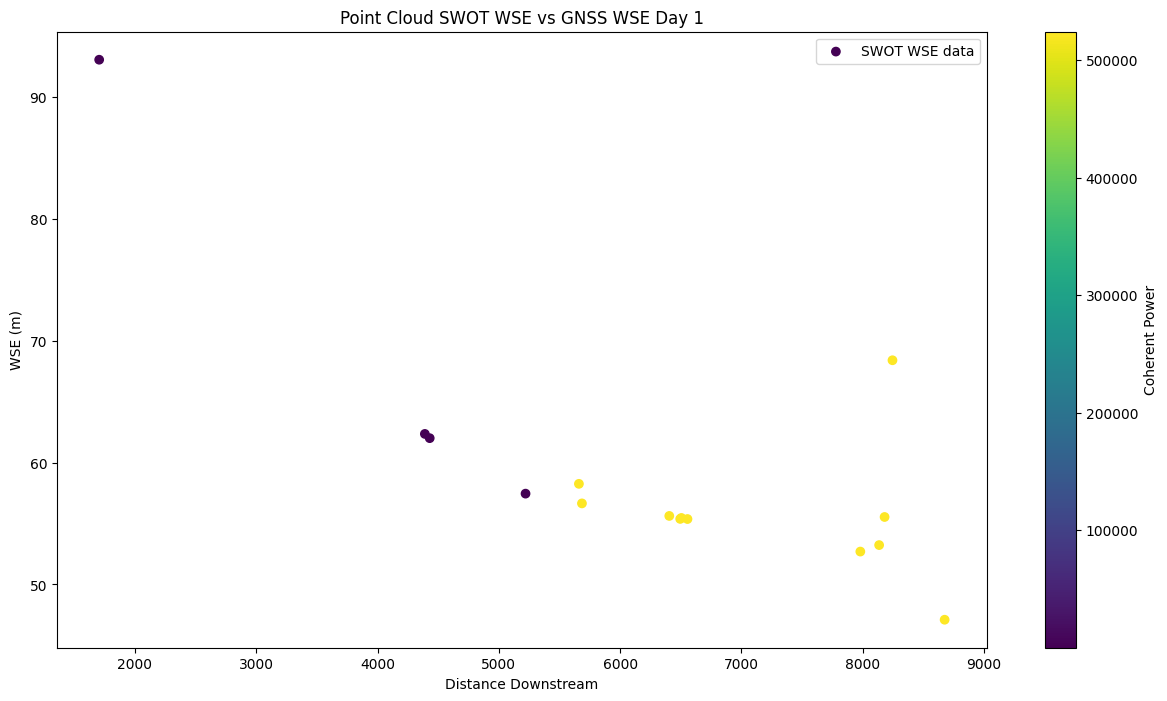

In [3]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)


# Apply filter to keep points where classification is greater than 2 and not 5
df_filtered = please[(please['classification'] > 2) & (please['classification'] !=5)]

sc = ax.scatter(df_filtered.cumulative_distance, df_filtered['height'], 
                c=df_filtered['geolocation_qual'], cmap='viridis', zorder=2, label='SWOT WSE data')

ax.legend()
ax.set_title('Point Cloud SWOT WSE vs GNSS WSE Day 1')
ax.set_xlabel('Distance Downstream')
ax.set_ylabel('WSE (m)')

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Coherent Power')

plt.show()